In [1]:
from __future__ import division
import numpy as np
import scipy.fftpack as sf
import matplotlib.pyplot as plt
import math
import pylab as pl
import scipy.signal as sig
from scipy import misc

## 1. STFT  (Short Time Fourier Transform) and source separation.

## In this part, we use STFT which is a collection of Fourier transform of a 1D signal on time subintervals. Why using STFT ?
- The length of a music signal for 4 minutes sampled at a rate of 44kHz is roughly $2500*44000 \simeq 1.1 \times 10^7$.
- The length of a music note is of the order of a tenth of a second.
### Conclusion: do not use FFT on the whole signal but on short segments of it.

### We use it in order to experiment source separation which comes from the idea that the different signals may present very different behaviour in the frequency domain.

In [2]:
# utils to load the sounds.
import numpy as np
import wave as wv

def load_sound(file, n0):
    
    x_raw = wv.open(file)
    n = x_raw.getnframes()
    x = np.frombuffer(x_raw.readframes(-1), 'Int16')
    x_raw.close()
    
    if file[::-1][:8][::-1] == "bird.wav":
        x = np.delete(x,list(range(6001)) + list(range(12500, 15001)) + list(range(22500, 24001)) + list(range(32500,34001)))

    if n0 !=0 and n0 < n:
        x = x[:n0]
    
    return x/np.max(x)

## Hereafter, we load the $3$ sounds and plot the second one.

In [3]:
n = 1024*16
s = 3 #number of signals.
x = np.zeros([n,3])
x[:,0] = load_sound("bird.wav",n)
x[:,1] = load_sound("female.wav",n)
x[:,2] = load_sound("male.wav",n)

## listen to a sound.
from IPython.display import Audio
Audio(x[:,1], rate = 15000)

<ipython-input-2-fc9e051fc462>:9: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  x = np.frombuffer(x_raw.readframes(-1), 'Int16')


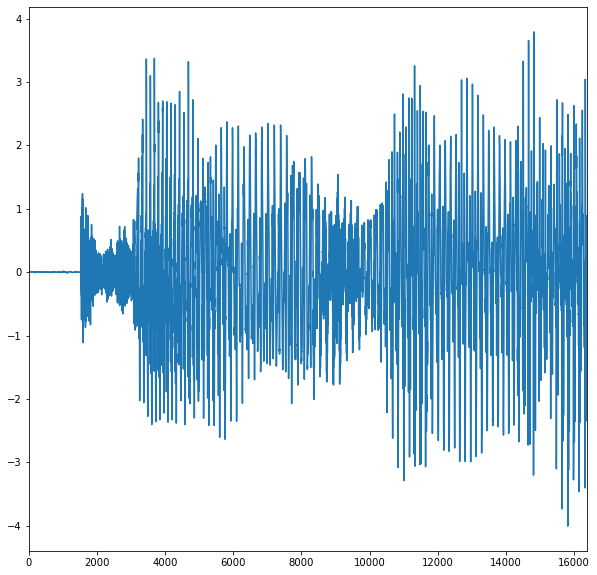

In [4]:
# Show the numerical signal.
x = x/np.tile(np.std(x,0),(n,1))
p = 2 #number of micros
import matplotlib.pyplot as plt
plt.figure(figsize = (10,10))
plt.xlim(0,n)
plt.plot(x[:,2])
plt.show()

### We simulate two micros which are implemented by linear combinations of the signals.

In [14]:
theta = np.linspace(0, np.pi, s + 1)[:-1]
theta[0] = .2
print("theta:", theta)
M = np.vstack((np.cos(theta), np.sin(theta)))
## recorded signals
mixedSignals = np.dot(x, M.T)
print("length of the signals", np.shape(mixedSignals))
# Listen to the two recorded signals.
from IPython.display import Audio
Audio(mixedSignals[:,1], rate = 15000)

theta: [0.2        1.04719755 2.0943951 ]
length of the signals (16384, 2)


### We use the STFT function from the python package signal and plot it.

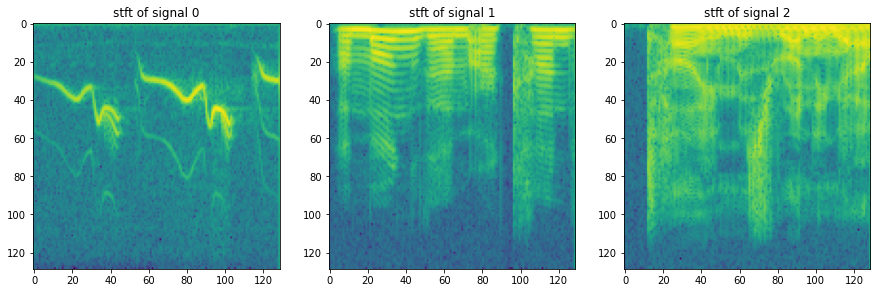

In [15]:
import scipy.signal as sig
plt.figure(figsize = (15,15))
for i in range(x.shape[-1]):
    f,t,w = sig.stft(x[:,i])
    plt.subplot(1,x.shape[-1],i+1)
    plt.title(f"stft of signal {i}")
    plt.imshow(np.log(np.abs(w)))

### We numerically check that the STFT and ISTFT are indeed inverse from each others.

In [16]:
[micro1, micro2] = mixedSignals.T # destructuring

stft = lambda im : sig.stft(im,noverlap = 64,nperseg = 128)
istft = lambda im : sig.istft(im,noverlap = 64,nperseg = 128)

f,t,w1 = stft(micro1)
f,t,w2 = stft(micro2)
print('w1:', w1.shape, ' w2:', w2.shape)
W = np.asarray([w1.flatten(),w2.flatten()])
print('W(',W.shape,'):', W)
t,recov = istft(w1)
print(np.sum((micro1 - recov)**2))

w1: (65, 257)  w2: (65, 257)
W( (2, 16705) ): [[ 1.16144549e-02+0.j  1.61385888e-02+0.j  1.85006418e-02+0.j ...
   1.18385135e-04+0.j  7.66135211e-04+0.j  4.97046266e-03+0.j]
 [ 2.27491165e-03+0.j  6.23925565e-03+0.j  4.34767210e-03+0.j ...
  -3.85635906e-05+0.j  2.08275687e-04+0.j  2.12086109e-03+0.j]]
1.152816428700722e-27


### By selecting randomly a group of points in time, we plot in the plane the coordinates of the points, being the measured signals by the micros.

16384


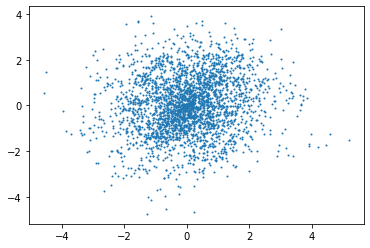

In [18]:
from random import shuffle
nbre_selec = 3000

def extractSomeValues(x, nb = 600): # along first axis
    randomId = np.arange(x.shape[0])
    shuffle(randomId)
    return x[randomId[:nb]]

print(mixedSignals.shape[0])

ySamples = extractSomeValues(mixedSignals, nbre_selec)
plt.plot(ySamples[:,0],ySamples[:,1],"o",markersize=1)
plt.show()

### Q1: Do the same with the STFT signals, what do you observe ?

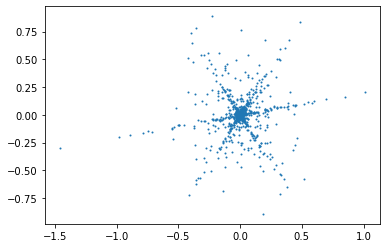

In [19]:
# W represent STFT signals

signal = W
#to have it in the good axis
signal = signal.T
#use on real part
signal = signal.real


stftSamples = extractSomeValues(signal, nbre_selec)
plt.plot(stftSamples[:,0],stftSamples[:,1],"o",markersize=1)
plt.show()

We observe that points congregates to 3 distincts lines that cross at a central point (the origin). 

### Q2: For each point in the plot above, compute its angle (angle between 2 points) and plot the distribution of the angles (use the function np.histogram) and plot it.

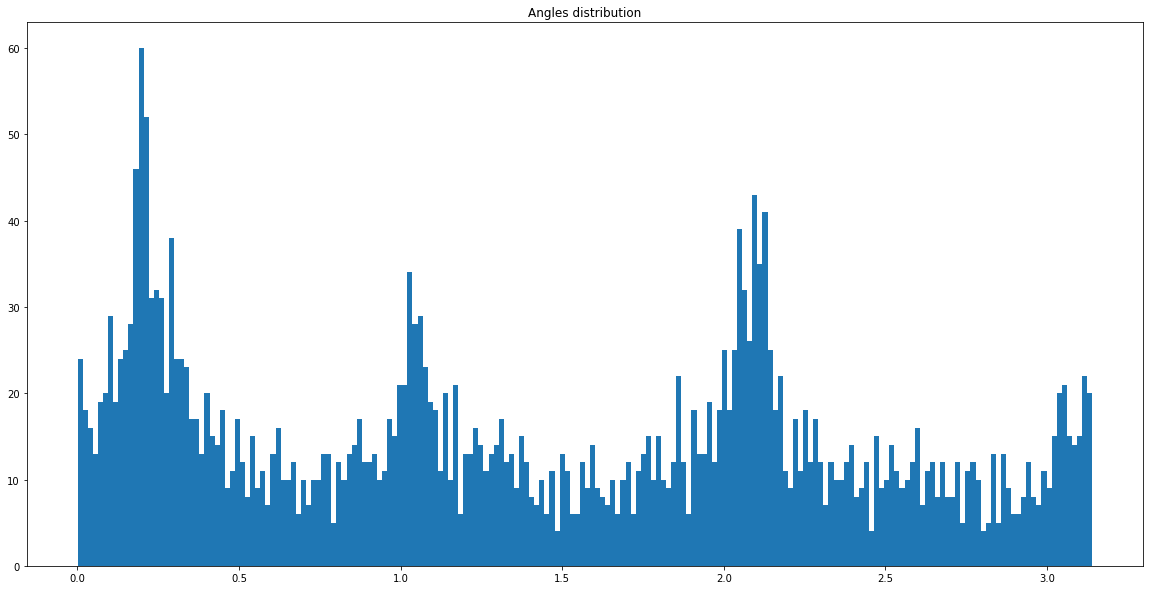

In [33]:
 #math.atan2() : Returns the tangent(y,x) in radius

pts = np.dstack((stftSamples[:,0],stftSamples[:,1]))[0]

angles = np.array([np.arctan2(p[1],p[0]) for p in pts])
angles = angle % np.pi #take angle between 0 and pi

resolution = 200
plt.figure(figsize=(20,10))
plt.title("Angles distribution")
histogram = plt.hist(angles, bins=resolution)
plt.show()

### Q3: By selecting the highest peaks of the distribution, estimate the angles of the mixing.

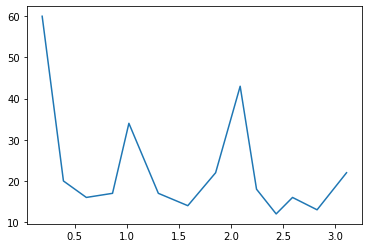

Angles :  [1.02108836 2.08835235 0.18925025]


In [58]:
#A bin is range that represents the width of a single bar of the histogram along the X-axis
peakCounts, peakBins = np.histogram(angles, bins= resolution)
#np.histogram computes the occurrences of input data that fall within each bin
#which in turns determines the area (not necessarily the height if the bins aren't of equal width) of each bar.

peaks, prop = sig.find_peaks(peakCounts, distance=10)
plt.plot(peakBins[peaks], peakCounts[peaks])
plt.show()

# sort by argument in order to find our maximal peaks
# ([-3:]) is used to keep only the first three maximum values
maxPeakIdx = peakCounts[peaks].argsort()[-3:]

peakAngles = peakBins[peaks][maxPeakIdx]
print("Angles : ", peakAngles)

### Q4: Using the STFT recorded signals, take each point in the plane and compute its projection on each recovered directions. It gives a vector of 3 estimated projections.

Angle :  1.0210883637660098
Angle :  2.088352354183552
Angle :  0.18925025358763106


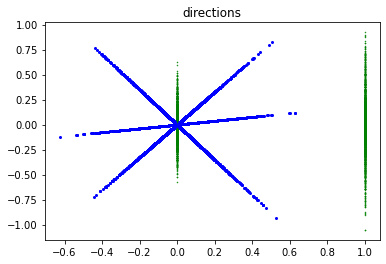

In [66]:
#https://stackoverflow.com/questions/9605556/how-to-project-a-point-onto-a-plane-in-3d
#https://gamedev.stackexchange.com/questions/72528/how-can-i-project-a-3d-point-onto-a-3d-line

directions = peakAngles
lines = []
dots = []

for angle in directions:
    print("Angle : ", angle)
    direction = [math.cos(angle), math.sin(angle)]
    # print(direction)
    dotAngles = np.dot(direction, direction) 
    lines.append(direction)
    dots.append(dotAngles)
    
projections = [[] for i in range(3)]
for pt in signal[:nbre_selec]:
    plt.plot(pt, "og", markersize=0.5)
    for i in range(len(lines)):
        direction = lines[i]
        A = [0,0]
        B = direction
        P = pt        
        dot_AP_AB = np.dot(pt, direction)
        dot_AB_AB = dots[i]
        multiplier = dot_AP_AB / dot_AB_AB
        projection = [ x * multiplier for x in direction ]
        projection.append(multiplier)
        projections[i].append(projection)
        plt.plot(projection[0], projection[1], "ob", markersize=2)

plt.title("directions")
plt.show()

### Q5: For each frequency point in the signal STFT, select the direction on which it has the largest projection. And threshold using the code below.

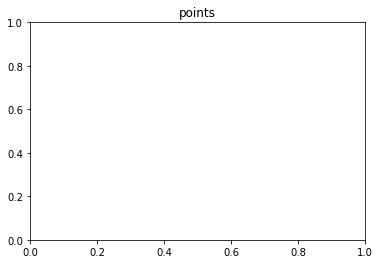

In [67]:
threshold = .005
#D = np.sqrt(np.sum(W**2, 0))
#I = I*(D > threshold)

projected_signal = []

for i in range(nbre_selec):
    pt = signal[i]
    largest_projection = None
    
plt.title("points")
plt.show()

### Q: Plot the STFT and the time domain of the recovered signals and the original signals. Estimate the performance using the SNR implemented below.

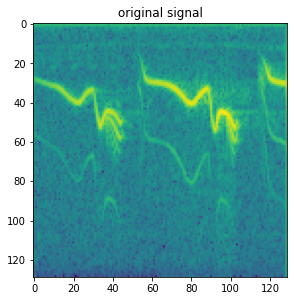

In [27]:
def snr(x, y):
    s =  np.linalg.norm(x - y)
    if s == 0:
        return "Equal inputs"
    return 20 * np.log10(np.linalg.norm(x) /s)

#t, recov = istft(projected_signal)

# plot
plt.figure(figsize = (10,10))
'''
plt.subplot(1,2,1)
plt.title("recovered signal")
plt.imshow(np.log(np.abs(projected_signal)))'''

plt.subplot(1,2,1)
plt.title("original signal")
plt.imshow(np.log(np.abs(w)))

plt.show()

### Q: Listen to the reconstructed signals and the original signals.

In [28]:
i = 0
from IPython.display import Audio
#Audio(X[i], rate = 15000)

In [29]:
i = 0
from IPython.display import Audio
Audio(x[:,i], rate = 15000)

TypeError: 'float' object is not subscriptable

# 2. The goal of this part is to explore implementations of a FIR or an IIR.

## We plot below a signal with a mix of low and high frequencies.

(1000,) (1000,)


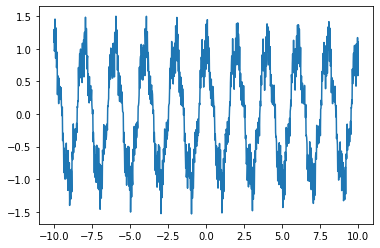

In [95]:
f = lambda t: np.cos(np.pi*t) + 0.2*np.sin(5*np.pi*t+0.1) + 0.2*np.sin(30*np.pi*t)  + 0.1*np.sin(32*np.pi*t+0.1) + 0.1*np.sin(47* np.pi*t+0.8)
t=np.linspace(-10,10,1000)
signal=f(t)
print(np.shape(t),np.shape(signal))
plt.plot(t, signal)

## Q1. Implement an ideal low pass filter using Fourier transform in 1D:
### Compute the inverse FFT of a low pass filter and cut it with a window that will be passed in argument and apply it to the signal above by convolution or using FFT.

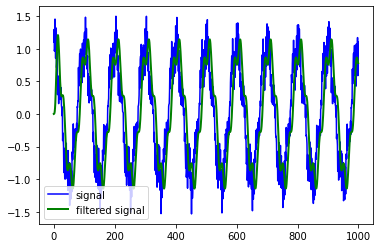

In [96]:
order = 5
sampling_freq = 30
cutoff_freq = 2
sampling_duration = 5
number_of_samples = sampling_freq * sampling_duration
normalized_cutoff_freq = 2 * cutoff_freq / sampling_freq

numerator_coeffs, denominator_coeffs = sig.butter(order, normalized_cutoff_freq)

filtered_signal = sig.lfilter(numerator_coeffs, denominator_coeffs, signal)

plt.plot(signal, 'b-', label='signal')
plt.plot(filtered_signal, 'g-', linewidth=2, label='filtered signal')
plt.legend()

## Q2. Using the code below, implement an IIR filter defined by its numerator which will be set to a  constant $b$ and its denominator which will be set to $1-az^{-1}$. 
### What can you say about the range of the parameter $a$ in order to obtain a stable filter. 
### Experimentally, determine the ranges of $a$ to get respectively a low-pass filter and a high-pass filter. Give a theoretical explanation.

$z^{-1} = \frac{Z^{-1}}{a − a_Z}$

In [97]:
def myIIR(x,a,b):
    ### a is the numerator
    ### b is the denominator
    assert(len(a)==len(b)),"a,b must have the same length"
    y = np.zeros_like(x)
    k = len(a)
    for i in range(len(a),len(x)):
        y[i] = np.sum(np.flipud(b)*y[i-k:i]) + np.sum(np.flipud(a) * x[i-k+1:i+1])
    return y

## In the following, we are given an electrocardiogram. We plot it as a function of time.

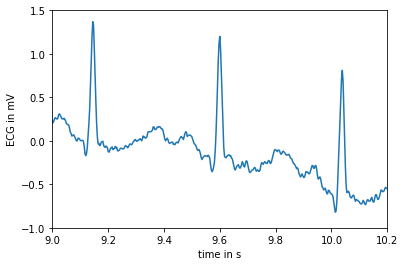

time min 0.0
time max 299.9972222222222


In [98]:
### load the data which is an electrocardiogram which is sampled at 360Hz
ecg = misc.electrocardiogram()
### Different plots.
fs = 360.0
### Since it is sampled at 360Hz, recall that Hz is the number of cycle per second, then the
### time is obtained as follows:
time = np.arange(ecg.size) / fs
### simple plot.
plt.plot(time, ecg)
plt.xlabel("time in s")
plt.ylabel("ECG in mV")
plt.xlim(9, 10.2)
plt.ylim(-1, 1.5)
plt.show()
print("time min", time[0])
print("time max", time[-1])

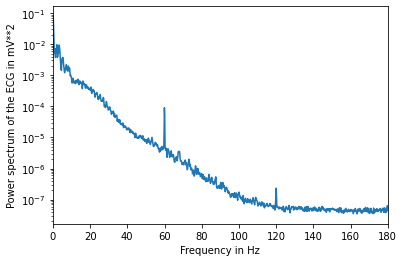

In [99]:
### Use the scipy function to get the power spectrum of the signal.
f, Pxx = sig.welch(ecg, fs=fs, nperseg=2048, scaling="spectrum")
plt.semilogy(f, Pxx)
plt.xlabel("Frequency in Hz")
plt.ylabel("Power spectrum of the ECG in mV**2")
plt.xlim(f[[0, -1]])
plt.show()

## Q3. Estimate the number of heartbeats in the following electrocardiogram and estimate the mean value of the interval between two heartbeats. You can use the method of your choice. A possible method consists in using a band pass filter and then extract the maximum values of the filtered signal.

Mean value :  54199


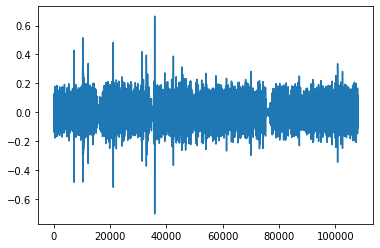

In [85]:
import statistics

fL = 0.1  # Cutoff frequency as a fraction of the sampling rate (in (0, 0.5)).
fH = 0.4  # Cutoff frequency as a fraction of the sampling rate (in (0, 0.5)).
b = 0.08  # Transition band, as a fraction of the sampling rate (in (0, 0.5)).

def band_pass():
    N = int(np.ceil((4 / b)))
    if not N % 2: N += 1  # Make sure that N is odd.
    n = np.arange(N)

    # Compute a low-pass filter with cutoff frequency fH.
    hlpf = np.sinc(2 * fH * (n - (N - 1) / 2))
    hlpf *= np.blackman(N)
    hlpf = hlpf / np.sum(hlpf)

    # Compute a high-pass filter with cutoff frequency fL.
    hhpf = np.sinc(2 * fL * (n - (N - 1) / 2))
    hhpf *= np.blackman(N)
    hhpf = hhpf / np.sum(hhpf)
    hhpf = -hhpf
    hhpf[(N - 1) // 2] += 1

    # Convolve both filters.
    return np.convolve(hlpf, hhpf)

h = band_pass()

s = np.convolve(ecg, h)
plt.plot(s)
peaksS, propS = sig.find_peaks(s)

meanVal = statistics.mean(peaksS)
print("Mean value : ", meanVal)